### 1 Setup

#### 1.1 Install Dependencies

In [24]:
# !pip install opencv-python

#### 1.2 Import Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

#### 1.3 Set GPU Growth

In [147]:
# for gpu in gpus:
#     print(gpu)

In [148]:
# import tensorflow as tf
# print("TF Version:", tf.__version__)
# print("Available GPUs:", tf.config.list_physical_devices('GPU'))

TF Version: 2.18.0
Available GPUs: []


In [149]:
# import tensorflow as tf
# print("CUDA Built:", tf.test.is_built_with_cuda())
# print("GPU Available:", tf.test.is_gpu_available())


CUDA Built: False
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: False


#### 1.4 Create Folder Structures

In [3]:
#setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os .path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [7]:
# #make directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

#### 2.Collect Positives and Anchors

#### 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# #Uncompress tar GZ labelled faces in the Wild dataset
# import zipfile; zipfile.ZipFile("lfw.zip").extractall(".")

In [47]:
# #Move LFW images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw',directory,file)
#         NEW_PATH = os.path.join(NEG_PATH,file)
#         os.replace(EX_PATH,NEW_PATH)

#### 2.2 Collect Positive and Anchor Classes

In [4]:
import uuid

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #cut down the frame
    frame  = frame[120:120+250,200:200+250,:]

    #collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create the unique file path
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)

    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create hte unique filepath
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))   
        #wrote positive image
        cv2.imwrite(imgname,frame)

    #show image back to the screen
    cv2.imshow('Image Collection',frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [41]:
frame

array([[[ 48,  86,  81],
        [ 51,  85,  81],
        [ 55,  83,  80],
        ...,
        [ 86, 109,  95],
        [ 86, 108,  96],
        [ 87, 109,  97]],

       [[ 48,  85,  80],
        [ 50,  84,  80],
        [ 55,  83,  80],
        ...,
        [ 86, 109,  96],
        [ 87, 109,  97],
        [ 87, 109,  98]],

       [[ 46,  81,  77],
        [ 48,  82,  78],
        [ 53,  82,  79],
        ...,
        [ 86, 109,  97],
        [ 87, 110,  99],
        [ 87, 110,  99]],

       ...,

       [[  0,   0,   2],
        [  0,   0,   2],
        [  0,   0,   1],
        ...,
        [  4,   0,   2],
        [  6,   0,   3],
        [  7,   0,   3]],

       [[  0,   0,   2],
        [  0,   0,   2],
        [  0,   0,   2],
        ...,
        [  4,   0,   2],
        [  5,   0,   2],
        [  6,   0,   3]],

       [[  0,   0,   3],
        [  0,   0,   2],
        [  0,   0,   2],
        ...,
        [  4,   0,   2],
        [  5,   0,   2],
        [  5,   0,   3]]

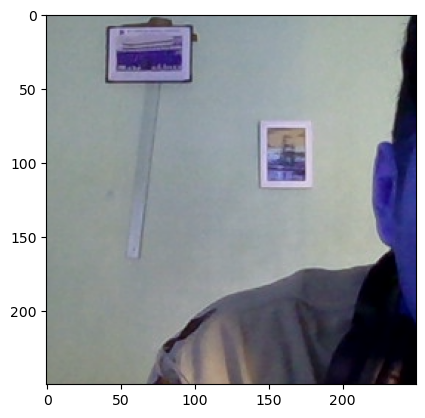

In [100]:
plt.imshow(frame)

In [99]:
frame.shape

(250, 250, 3)

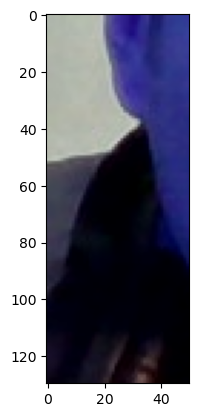

In [97]:
plt.imshow(frame[120:120+250,200:200+250,:])

### 3. Load and Preprocess Images

#### 3.1 Get Image Directories

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
print(dir_test.next())

b'data\\anchor\\b7d5437c-23ed-11f0-a989-f47b0953051f.jpg'


#### 3.2 Preprocessing- Scale and Resize

In [7]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)

    #load the image as jpeg
    img = tf.io.decode_jpeg(byte_img)

    #preprocessing steps- resizing the image to be 100x100x3
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img
    

In [9]:
img = preprocess('data\\anchor\\c8935a7f-1f8a-11f0-8619-f47b0953051f.jpg')

In [10]:
img.numpy().max()

1.0

#### 3.3 Create Labelled Dataset

In [159]:
#(anchor,positive) => 1,1,1,1
# (anchor,negative) => 0,0,0,0


In [8]:
positives = tf.data.Dataset.zip(anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives= tf.data.Dataset.zip(anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data = positives.concatenate(negatives)


#### 3.4 Build Train and Test Partition

In [9]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [10]:
#dataloading pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [14]:
sample = data.as_numpy_iterator()

In [15]:
samp = sample.next()

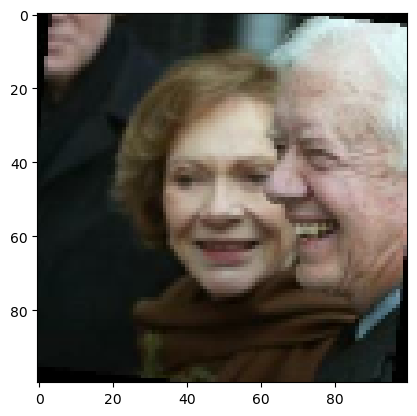

In [15]:
plt.imshow(samp[1])

In [16]:
samp[2]

0.0

In [11]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [12]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### 4. Model Build

### 4.1 Embedding Layer

In [19]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [20]:
embedding = make_embedding()

In [21]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

#### 4.2 Build Distance Layer

In [13]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

#### 4.3 Build siamese Model

In [19]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [20]:
siamese_model = make_siamese_model()

In [21]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Training

#### 5.1 Setup Optimizer and Loss function

In [14]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [15]:
opt = tf.keras.optimizers.Adam(1e-4)

#### 5.2 Establish Checkpoints

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)


#### 5.3 Build Train Step Function

In [25]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative
        X = batch[:2]
        #get label
        y = batch[2]
        #forward pass
        yhat = siamese_model(X,training=True)
        #calculate loss
        loss = binary_cross_loss(y,yhat)

    print(loss)
    #calculate gradients
    grad = tape.gradient(loss,siamese_model.trainable_variables)

    #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

#### 5.4 Build a training loop

In [26]:
def train(data,EPOCHS):
    #loop through epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(train_data))

        #loop through each batch
        for idx,batch in enumerate(data):
            #run train step here
            train_step(batch)
            progbar.update(idx+1)

        #save checkpoints
        if epoch % 10 == 0:
           checkpoint.save(file_prefix = checkpoint_prefix)
            

#### 5.5 Train the model

In [27]:
EPOCHS = 50

In [28]:
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 894ms/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 842ms/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 852ms/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 854ms/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 859ms/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 864ms/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 865ms/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 891ms/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 852ms/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 891ms/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 865ms/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 861ms/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 863ms/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━

### 6. Evaluate Model

#### 6.1 Importing metrics

In [16]:
#Import metric calculations
from tensorflow.keras.metrics import Precision,Recall

In [49]:
#Get a batch of a test data
test_input,test_val,y_true = test_data.as_numpy_iterator().next()

#### 6.2 Make Predictions

In [51]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]

In [52]:
y_true

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [53]:
#creating a metric object
m = Recall()

#calculating the recall value
m.update_state(y_true,y_hat)


m.result().numpy()

1.0

#### 6.4 Viz Results

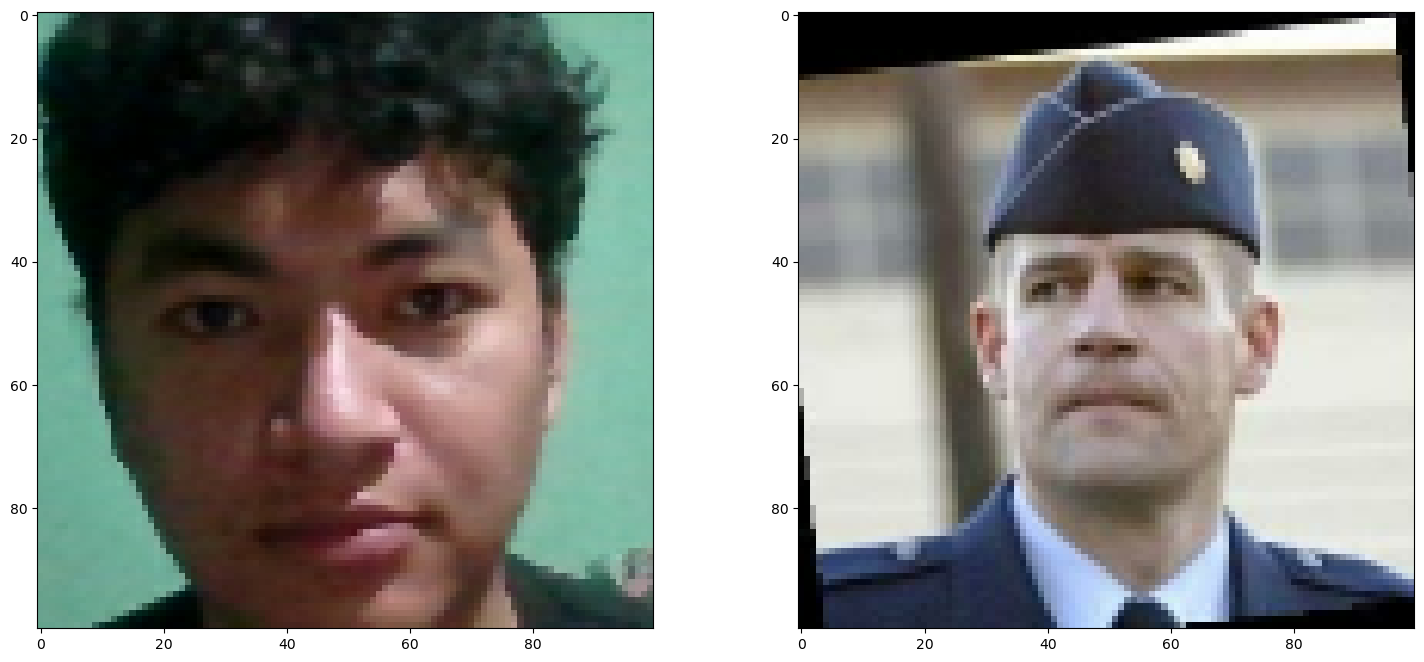

In [55]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()


### 7. Save the model

In [56]:
#Save weights
siamese_model.save('siamesemodel.h5')

In [17]:
#reload the model
model = tf.keras.models.load_model('siamesemodel.h5',
                                 custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [26]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\27582474-1f8b-11f0-bd0d-f47b0953051f.jpg
application_data\verification_images\27903989-1f8b-11f0-9002-f47b0953051f.jpg
application_data\verification_images\28679878-1f8b-11f0-a454-f47b0953051f.jpg
application_data\verification_images\29297458-1f8b-11f0-909f-f47b0953051f.jpg
application_data\verification_images\29597552-1f8b-11f0-9785-f47b0953051f.jpg
application_data\verification_images\31075845-1f8b-11f0-b7d4-f47b0953051f.jpg
application_data\verification_images\31432420-1f8b-11f0-85fd-f47b0953051f.jpg
application_data\verification_images\32812413-1f8b-11f0-914c-f47b0953051f.jpg
application_data\verification_images\33732357-1f8b-11f0-a2e5-f47b0953051f.jpg
application_data\verification_images\33947427-1f8b-11f0-a66a-f47b0953051f.jpg
application_data\verification_images\3581194b-1f8b-11f0-b462-f47b0953051f.jpg
application_data\verification_images\36191089-1f8b-11f0-8015-f47b0953051f.jpg
application_data\verification_images\366372a1-1f8b-11f0-804f-f47

### 8. Real Time Test

#### 8.1 Verification Function

In [18]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified


In [20]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

#### 8.2 OpenCV Real Time Verification

In [20]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[120:120+250,200:200+250]
    cv2.imshow('Verification',frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'), frame)
        #Run verification
        results,verified = verify(model,0.9,0.7)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━